# Determine accuracy of planet coordinates for STK and OFLS ephemerides

This notebook empirically determines the accuracy of two functions, 
comparing to the "gold standard" of JPL Horizons:

- `get_planet_chandra`: uses DE432 + OFLS/STK Chandra ephemeris to compute relative to Chandra
- `get_planet_eci`: uses DE432 and computes relative to Earth

This covers dates from 2016-01-01 to 2025-10-20. Note that prior to 2016 the STK
orbit ephemeris data may be inaccurate.

## `get_planet_chandra` errors

- Venus: < 0.25 arcsec with a peak around 0.02
- Mars: < 0.45 arcsec with a peak around 0.1
- Jupiter: < 0.2 arcsec with a peak around 0.1
- Saturn: < 0.2 arcsec with a peak around 0.1

## `get_planet_eci` errors

The larger errors are due to ignoring the Chandra orbit.

- Venus: < 12 arcmin with peak around 2 arcmin
- Mars: < 8 arcmin with peak around 1.5 arcmin
- Jupiter: < 1 arcmin with peak around 0.5 arcmin
- Saturn: < 0.5 arcmin with peak around 0.3 arcmin

In [1]:
import sys
sys.path.insert(0, "..")

from chandra_aca.planets import (
    get_planet_chandra,
    get_planet_barycentric,
    get_planet_eci,
    get_planet_chandra_horizons,
)
from chandra_aca.transform import eci_to_radec
from agasc import sphere_dist
import matplotlib.pyplot as plt
import matplotlib.style
from functools import lru_cache
from cheta import fetch
from cxotime import CxoTime
from ska_matplotlib import plot_cxctime

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
get_planet_chandra_horizons = lru_cache(maxsize=32)(get_planet_chandra_horizons)

In [3]:
# @lru_cache
def compare_methods(body, start, stop, n_times=1000, ephem_source="cxc"):
    pos = get_planet_chandra_horizons(body, start, stop, n_times=n_times)
    pos["err-ephem"] = 0.0
    pos["err-earth"] = 0.0

    eci = get_planet_eci(body, pos["time"])
    body_ra, body_dec = eci_to_radec(eci)
    pos["err-earth"] = sphere_dist(pos["ra"], pos["dec"], body_ra, body_dec) * 3600

    eci = get_planet_chandra(body, pos["time"], ephem_source=ephem_source)
    body_ra, body_dec = eci_to_radec(eci)
    pos["err-ephem"] = sphere_dist(pos["ra"], pos["dec"], body_ra, body_dec) * 3600

    return pos

In [4]:
def plot_errors_one(ax1, ax2, body, n_times=1000, save=False, ephem_source="cxc"):
    pos = compare_methods(body, start="2016-01-01", stop="2025-10-20", n_times=n_times, ephem_source=ephem_source)
    ax1.hist(pos["err-ephem"], bins=50)
    ax1.set_title(f"{body} get_planet_chandra errors ({ephem_source})")
    ax1.set_xlabel("arcsec")
    ax2.hist(pos["err-earth"], bins=50)
    ax2.set_title(f"{body} get_planet_eci errors")
    ax2.set_xlabel("arcsec")
    if save:
        plt.savefig(f"planet-errors-{body}.png")

In [5]:
def plot_errors(body, ntimes=1000):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    for ephem_source, (ax1, ax2) in zip(("cxc", "stk"), axes):
        plot_errors_one(ax1, ax2, body, n_times=ntimes, ephem_source=ephem_source)
    x0 = min(axes[0][0].get_xlim()[0], axes[1][0].get_xlim()[0])
    x1 = max(axes[0][0].get_xlim()[1], axes[1][0].get_xlim()[1])
    axes[0][0].set_xlim(x0, x1)
    axes[1][0].set_xlim(x0, x1)
    fig.tight_layout()

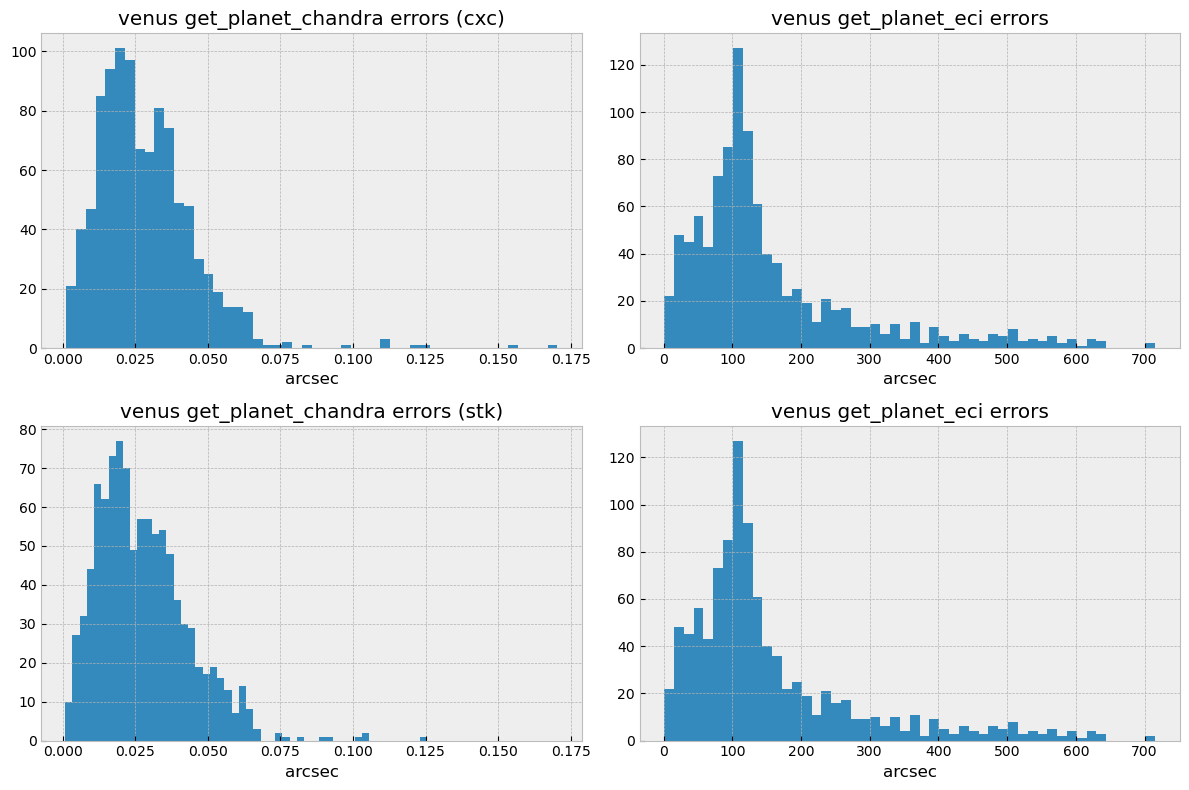

In [6]:
plot_errors("venus")


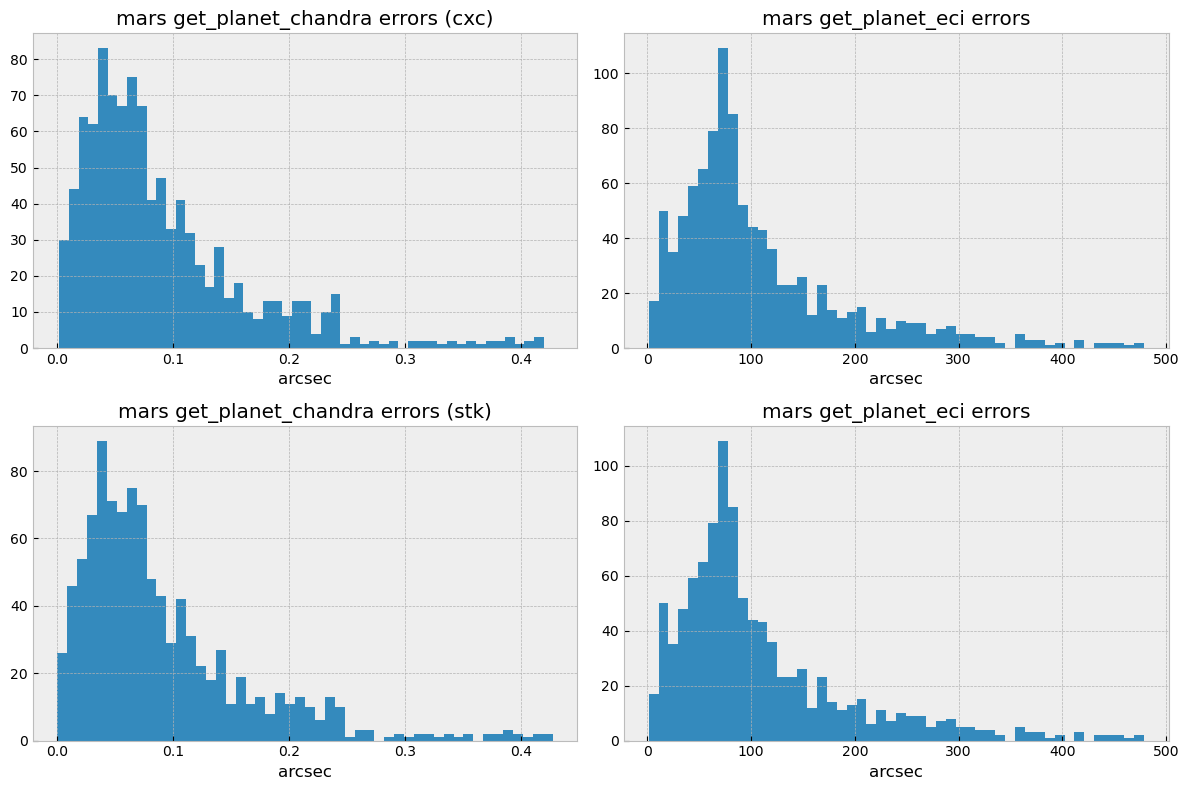

In [7]:
plot_errors("mars")

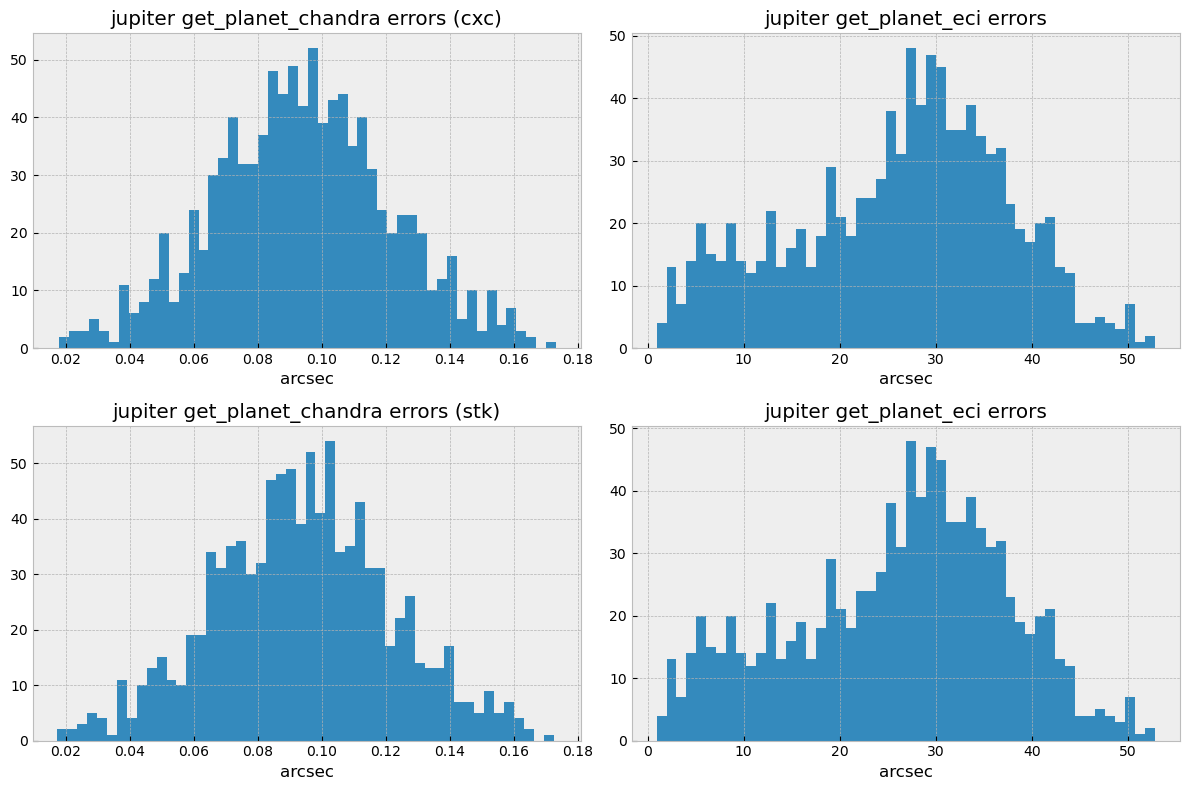

In [8]:
plot_errors("jupiter")

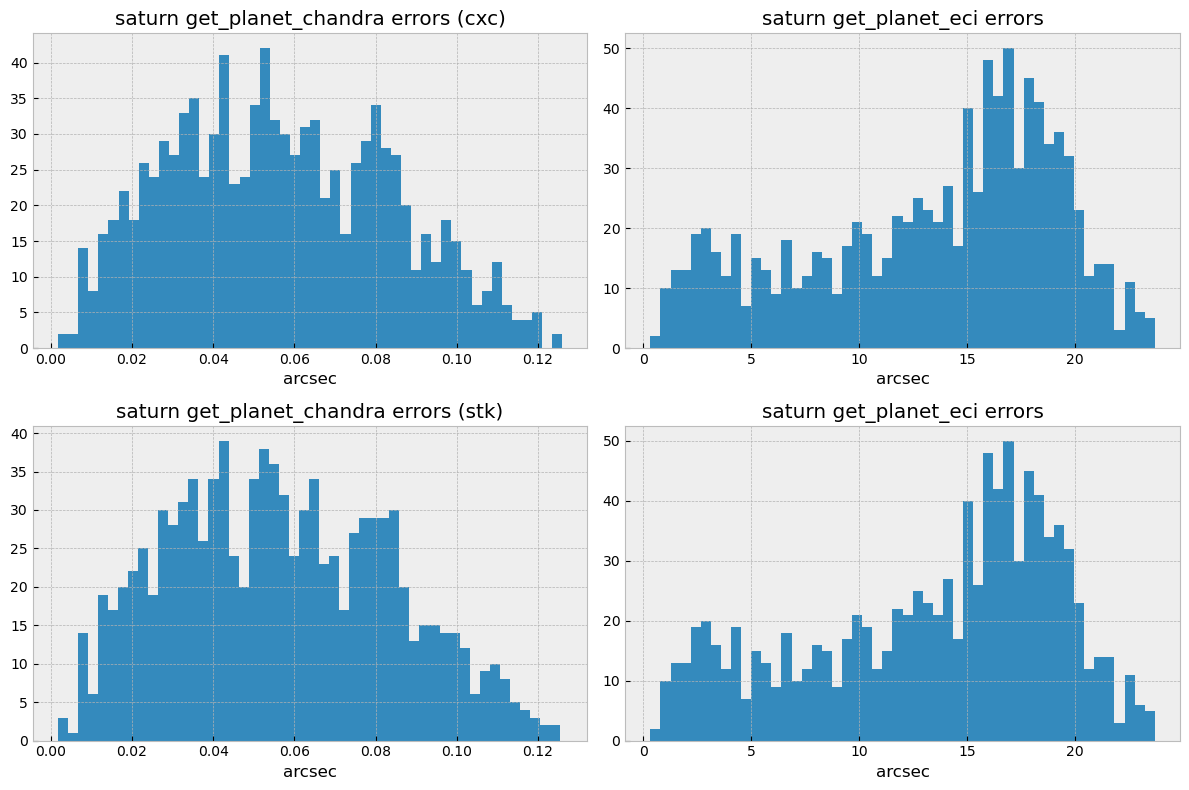

In [9]:
plot_errors("saturn")